# define function

    import libraries

    showeig(EIG)
    
    showemb(EMB)
    
    showdelta(delta,lab='')
    
    Mdel(EIG,EMB,flag=1)
    - compute difference between eigenpairs of different n's
    - flag: whether dataset touchs 1
    
    Mdeltor(EIG,EMB,real,skip=0)
    - compute difference between eigenpairs of the real one and others
    - skip: index parameter

    MK(X,Y,sigma)
    - kernel function
    - connectivity between each x in X and y in Y
    
    DM(X,n,dim,sigma=1)
    - discrete X
    - compute the eigenpair of the diffusion matrix
    - default sigma=1
    - eigenvectors scale by sqrt(n)
    
    DMc(X,n,dim,sigma=1)
    - continuous X
    - compute the approximation of the eigenpair of the diffusion operator
    - default sigma=1
    - eigenvectors scale by sqrt(n)

In [1]:
%pylab inline

from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation as ani
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds, eigs
from scipy.special import erf
from numpy.matlib import repmat

set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

Populating the interactive namespace from numpy and matplotlib


In [2]:
def showeig(EIG, real=[],lab='n='):
    cmap = cm.brg
    col = cmap(linspace(0,1,len(EIG)))
    
    dim = len(next(iter(EIG.values())))
    
    j = 0
    print('eigenvalue:')
    for i in EIG.keys():
        plot(range(dim), EIG[i], color=col[j], marker='.', markersize=10, label=lab+i)
        print(EIG[i], lab,i)
        j += 1

    if len(real)>0: 
        plot(range(dim), real, color='gold', marker='.', markersize=10, label='real')
        print(real, 'real')
        
    plt.gcf().set_size_inches(6,6)
    plt.title('eigenvalues')
    plt.legend()
    plt.show()

In [3]:
def showemb(EMB, real=[],lab='n='):
    cmap = cm.brg
    col = cmap(linspace(0,1,len(EMB)))
    
    j = 0
    for i in EMB.keys():
        plot(EMB[i][:,1],EMB[i][:,2], color=col[j], label=lab+i)
        j += 1

    if len(real)>0: plot(real[:,1],real[:,2], color='gold', label='real')
    
    plt.gcf().set_size_inches(6,6)
    plt.title('embeddings')
    plt.legend()
    plt.show()

In [4]:
def showdelta(delta,lab=''):
    p,q = delta.shape
        
    cmap = cm.hsv
    col = cmap(linspace(0,.65,p))
    
    print(lab+'delta:')
    for i in range(p):
        plot(range(1,q+1),delta[i,:],color=col[i],marker='.',markersize=10,label=lab+str(i))
        print(delta[i,:])

    plt.gcf().set_size_inches(6,6)
    plt.title(lab+'delta')
    if p>1: plt.legend()
    plt.show()

In [9]:
def Mdel(EMB,EIG={},flag=1):
    
    I = list(EMB.keys())
    dim = EMB[str(I[0])].shape[1]
    
    delv = []
    dele = []

    j = 0
    for i in I[:-1]:
        if flag: k = str(int(i)*2-1)
        else:    k = str(int(i)*2)
        
        if len(EIG)>0: dele.extend(abs(EIG[str(k)] - EIG[i]))

        tmp = (EMB[k][::2**(j+1),:]-EMB[i][::2**j,:])**2
        delv.append(sqrt(sum(tmp)))
        j += 1

    delv = array(delv).reshape(1,len(I)-1)
    
    if len(EIG)>0: dele = array(dele).reshape(len(I)-1,dim)

    return delv, dele

In [10]:
def Mdeltor(real,EMB,EIG={},skip=0):
    
    I = list(EMB.keys())
    dim = EMB[str(I[0])].shape[1]
    
    delv = []
    dele = []

    j = 0
    for i in EMB.keys():   
        if len(EIG)>0: dele.extend(abs(EIG[i] - real['EIG']))

        if skip: tmp = (EMB[i][::2**j,:]-real['EMB'][::2**real['p'],:])**2
        else:    tmp = (EMB[i]-real['EMB'])**2

        delv.append(sqrt(sum(tmp)))
        j += 1
    
    delv = array(delv).reshape(1,len(I))

    if len(EIG)>0: dele = array(dele).reshape(len(I),dim)
    
    return delv, dele

In [11]:
def MK(X,Y,sigma):
    
    n = X.shape[0]
    m = Y.shape[0]
    
    X = repmat(X.reshape((n,1)),1,m)
    Y = repmat(Y,n,1)
        
    dist = abs(X-Y)
    
    return exp(-dist**2/sigma)

In [47]:
def MKl(X,Y,s):
    
    n = X.shape[0]
    m = Y.shape[0]
    
    X = repmat(X.reshape((n,1)),1,m)
    Y = repmat(Y,n,1)
        
    dist = abs(X-Y)
    
    dists = sort(dist, axis=0)
    tmp   = dists[s+1,:]
    tmp[argwhere(tmp==0)] = 1e-5
    sigma = diag(1/tmp) 
    
    return exp(-sigma.dot(dist**2).dot(sigma))

In [13]:
def DM(X,n,dim,sigma,local):
    
    if local: K = MKl(X,X,sigma)
    else:     K = MK(X,X,sigma)
        
    D = diag(1/(sum(K,axis=1)))
    P = D.dot(K)
        
    S,U = eigs(P,dim)
        
    L = diag(S.real)
    U = (U.real)*sqrt(n)
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
    
    return U.dot(L), S.real, U

In [14]:
def DMc(X,n,dim,sigma):
    
    Y = (arange(n)+1/2)/n
    
    K = MK(X,Y,sigma)
    D = diag(2/(sqrt(pi)*(erf(X)-erf(X-1))))
    P = (D.dot(K))*(1/n)
    
    S,U = eigs(P,dim)

    L = diag(S.real)
    U = (U.real)*sqrt(n)
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
        
    return U.dot(L), S.real, U

In [16]:
dim = 6

# 1. numerical integration

Find the eigenvalues and eigenfunctions of $P$ by approximating the integral.

### function: test1(n,q,dim=5,sigma=1)

input

    n: initial size 
    p: number of time we double the size
    dim: embedding dimension (optional, default=5+1)
	sigma: scaling parameter (optional, default=1)
    flag: flag=1 if X=[0,1], flag=0 if X=[0,1) (optional, default=1)
    
output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [17]:
def test1(n,p,dim=6,sigma=1,flag=1):
    EMB = {}
    EIG = {}
    VEC = {}
    
    for i in range(p):
        t = time.time()
                
        if flag: 
            m = n*(2**i)+1
            X = linspace(0,1,m)
        else:
            m = n*(2**i)
            X = arange(m)/m
                                
        EMB[str(m)], EIG[str(m)], VEC[str(m)] = DMc(X,m,dim,sigma)
        
        print('n = ',m, '    duration... ', '%.4f'%(time.time()-t),'s')

    return EMB, EIG, VEC

In [88]:
n = 10
p = 10
EMB1, EIG1, VEC1 = test1(n,p)

n =  11     duration...  0.0015 s
n =  21     duration...  0.0020 s
n =  41     duration...  0.0014 s
n =  81     duration...  0.0020 s
n =  161     duration...  0.0025 s
n =  321     duration...  0.0051 s
n =  641     duration...  0.0189 s
n =  1281     duration...  0.1113 s
n =  2561     duration...  0.4292 s
n =  5121     duration...  2.3648 s


### eigenvalues and embeddings

eigenvalue:
[1.00049 0.16869 0.01207 0.00053 0.00002 0.00000] n= 11
[1.00014 0.16184 0.01131 0.00050 0.00002 0.00000] n= 21
[1.00004 0.15824 0.01086 0.00048 0.00002 0.00000] n= 41
[1.00001 0.15639 0.01062 0.00046 0.00001 0.00000] n= 81
[1.00000 0.15546 0.01050 0.00045 0.00001 0.00000] n= 161
[1.00000 0.15498 0.01043 0.00045 0.00001 0.00000] n= 321
[1.00000 0.15475 0.01040 0.00045 0.00001 0.00000] n= 641
[1.00000 0.15463 0.01039 0.00045 0.00001 0.00000] n= 1281
[1.00000 0.15457 0.01038 0.00045 0.00001 0.00000] n= 2561
[1.00000 0.15454 0.01038 0.00045 0.00001 0.00000] n= 5121


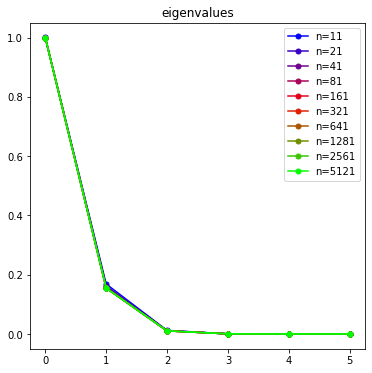

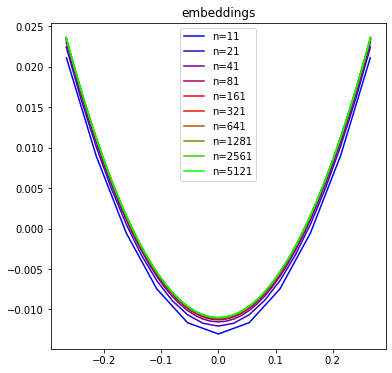

In [89]:
showeig(EIG1)
showemb(EMB1)

### difference between eigenvalues & embedding of each $n$’s

eig_delta:
[0.00035 0.00010 0.00003 0.00001 0.00000 0.00000 0.00000 0.00000 0.00000]
[0.00685 0.00360 0.00185 0.00094 0.00047 0.00024 0.00012 0.00006 0.00003]
[0.00077 0.00045 0.00024 0.00012 0.00006 0.00003 0.00002 0.00001 0.00000]
[0.00003 0.00002 0.00001 0.00001 0.00000 0.00000 0.00000 0.00000 0.00000]
[0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
[0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]


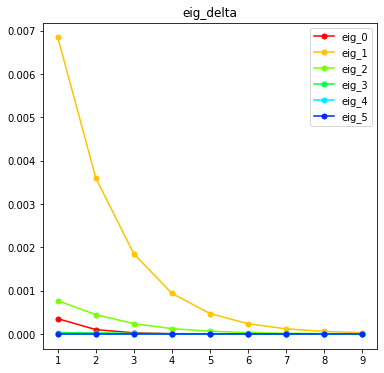

emb_delta:
[0.00400 0.00190 0.00093 0.00046 0.00023 0.00011 0.00006 0.00003 0.00001]


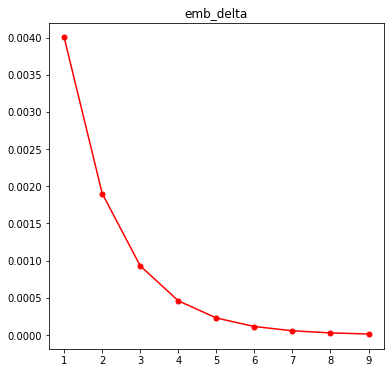

In [90]:
delv1,dele1 = Mdel(EMB1,EIG1,flag=1)

showdelta(dele1.transpose(),'eig_')
showdelta(delv1,'emb_')

In [92]:
real = {}
real['n'] = n*(2**(p-1))+1
real['p'] = p-1
real['EIG'] = EIG1[str(real['n'])]
real['EMB'] = EMB1[str(real['n'])]
real['VEC'] = VEC1[str(real['n'])]

# 2. convergence  to the diffusion operator

We see the eigenpairs of `n = 5121` above as the real eigenpairs. 

Check whether the eigenparis of diffusion matrix converge to the real eigenpairs of the diffusion operator.

### function: test2(n,p,dim=6,sigma=1,flag=1):

input

    n: initial size 
    p: number of time we double the size
    dim: embedding dimension (optional, default=5+1)
    sigma: scaling parameter (optional, default=1)
    flag: flag=1 if X=[0,1], flag=0 if X=[0,1) (optional, default=1)
    
output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [93]:
def test2(n,p,dim=6,sigma=1,flag=1,local=0):
    EMB = {}
    EIG = {}
    VEC = {}
    
    for i in range(p):
        t = time.time()
                
        if flag: 
            m = n*(2**i)+1
            X = linspace(0,1,m)
        else:
            m = n*(2**i)
            X = arange(m)/m
                                
        EMB[str(m)], EIG[str(m)], VEC[str(m)] = DM(X,m,dim,sigma,local)
        
        print('n = ',m, '    duration... ', '%.4f'%(time.time()-t),'s')

    return EMB, EIG, VEC

In [94]:
n = 10
q = 10
EMB2, EIG2, VEC2 = test2(n,q,flag=1)

n =  11     duration...  0.0015 s
n =  21     duration...  0.0016 s
n =  41     duration...  0.0017 s
n =  81     duration...  0.0050 s
n =  161     duration...  0.0084 s
n =  321     duration...  0.0052 s
n =  641     duration...  0.0263 s
n =  1281     duration...  0.0840 s
n =  2561     duration...  0.4407 s
n =  5121     duration...  2.5356 s


### eigenvalues & embeddings

eigenvalue:
[1.00000 0.18262 0.01440 0.00070 0.00002 0.00000] n= 11
[1.00000 0.16862 0.01237 0.00058 0.00002 0.00000] n= 21
[1.00000 0.16158 0.01137 0.00051 0.00002 0.00000] n= 41
[1.00000 0.15805 0.01087 0.00048 0.00002 0.00000] n= 81
[1.00000 0.15628 0.01062 0.00046 0.00001 0.00000] n= 161
[1.00000 0.15540 0.01050 0.00045 0.00001 0.00000] n= 321
[1.00000 0.15495 0.01043 0.00045 0.00001 0.00000] n= 641
[1.00000 0.15473 0.01040 0.00045 0.00001 0.00000] n= 1281
[1.00000 0.15462 0.01039 0.00045 0.00001 0.00000] n= 2561
[1.00000 0.15457 0.01038 0.00045 0.00001 0.00000] n= 5121
[1.00000 0.15454 0.01038 0.00045 0.00001 0.00000] real


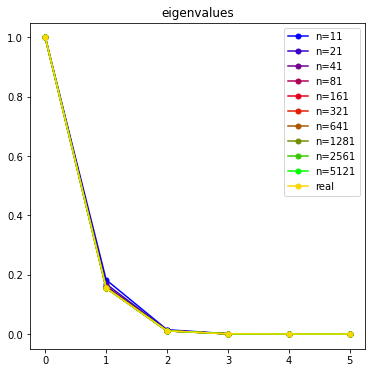

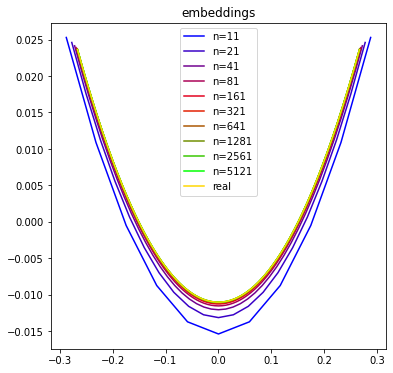

In [95]:
showeig(EIG2,real['EIG'])
showemb(EMB2,real['EMB'])

### difference between eigenvalues & embedding of each $n$’s and the real one

eig_delta:
[0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]
[0.00115 0.00029 0.00007 0.00002 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]
[0.00044 0.00011 0.00003 0.00001 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]
[0.00005 0.00001 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]
[0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]
[0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000
 0.00000]


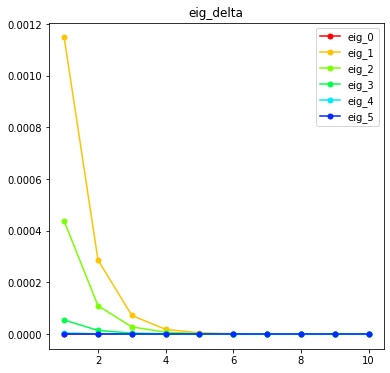

emb_delta:
[0.08490 0.04238 0.02109 0.01044 0.00512 0.00246 0.00113 0.00047 0.00014
 0.00003]


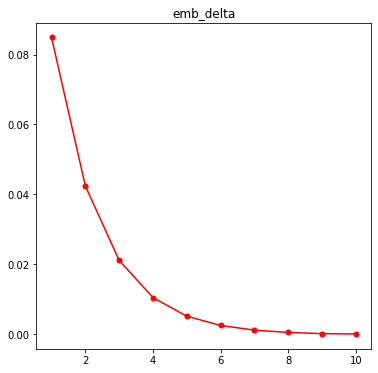

In [84]:
delv2,dele2 = Mdeltor(real,EMB2,EIG2,skip=1)

showdelta(dele2.transpose(),'eig_')
showdelta(delv2,'emb_')

# 2.5 Nystrom extension



In [85]:
def nystrom(EIG,EMB,dim=6,sigma=1,flag=1):

    I = list(EIG.keys())
    dim = len(next(iter(EIG.values())))
    
    EMBext = {}
    
    z = int(I[-1])    
    if flag: Z = linspace(0,1,z)
    else:    Z = arange(z)/z
    
    j = 0
    for i in I:
        inda = arange(int(i))*(2**(len(I)-1-j))
        indb = delete(arange(z),inda)
        X = Z[inda]
        Y = Z[indb]
                
        Kadd = MK(Y,X,sigma)
        Dadd = diag(1/sum(Kadd,axis=1))
    
        EMBi = zeros((z,dim))
        EMBi[inda,:] = EMB[i]
        EMBi[indb,:] = Dadd.dot(Kadd).dot(EMB[i]).dot(diag(1/EIG[i]))
        
        EMBext[i] = EMBi
        j += 1
    
    EMBext[str(z)] = EMB[str(z)]
    
    return EMBext

In [86]:
%%time

EMBext = nystrom(EIG2,EMB2,flag=0)

CPU times: user 7.05 s, sys: 1.74 s, total: 8.78 s
Wall time: 1.84 s


### embeddings & thier distance to the real embedding

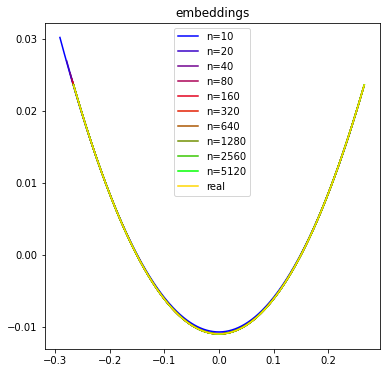

ext_emb_delta:
[1.91533 0.95754 0.47681 0.23622 0.11589 0.05573 0.02564 0.01060 0.00308
 0.00069]


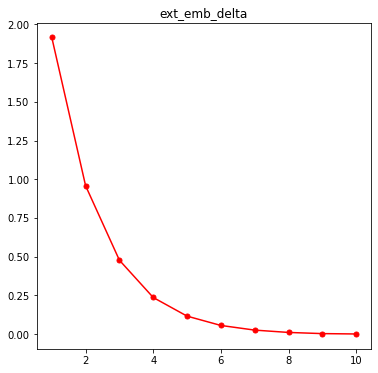

In [87]:
delv25,_ = Mdeltor(real,EMBext)

showemb(EMBext,real['EMB'])
showdelta(delv25,'ext_emb_')

# 3. sigma effect

For a given dataset, test the effect of setting different sigma's (global & local scaling parameter).

### function:  test3(n,s,dim=6,flag=1)

input

    n: data size
    s: local scaling parameter
    sigma: global scaling parameter, an array of #a values uniformly lie between (0,b]
    dim: embedding dimension (optional, default=5+1)
    flag: flag=1 if X=[0,1], flag=0 if X=[0,1) (optional, default=1)    
    
output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [71]:
def test3(n,s,dim=6,flag=1):
    EMB = {}
    EIG = {}
    VEC = {}
    
    if flag: X = linspace(0,1,n)
    else:    X = arange(n)/n

    EMB['local'], EIG['local'], VEC['local'] = DM(X,n,dim,int(s[0]),1)
    
    for i in range(1,len(sigma)):
        EMB[str(s[i])], EIG[str(s[i])], VEC[str(s[i])] = DM(X,n,dim,s[i],0)

    return EMB, EIG, VEC

In [72]:
%%time

n = 500 #real['n']
a = 10
b = .5
sigma = arange(1,a+1)/a*b
s = hstack(([7],sigma))

EMB3, EIG3, VEC3 = test3(n,s)

CPU times: user 332 ms, sys: 415 ms, total: 747 ms
Wall time: 152 ms


### eigenvalues & embeddings

eigenvalue:
[1.00000 0.99984 0.99937 0.99858 0.99748 0.99606] n= local
[1.00000 0.85765 0.57249 0.31866 0.15166 0.06252] n= 0.05
[1.00000 0.72734 0.35022 0.12888 0.03770 0.00907] n= 0.1
[1.00000 0.62144 0.23077 0.06189 0.01274 0.00211] n= 0.15
[1.00000 0.53753 0.16103 0.03356 0.00528 0.00066] n= 0.2
[1.00000 0.47100 0.11759 0.01993 0.00253 0.00026] n= 0.25
[1.00000 0.41771 0.08908 0.01269 0.00134 0.00011] n= 0.3
[1.00000 0.37444 0.06953 0.00852 0.00078 0.00006] n= 0.35
[1.00000 0.33880 0.05563 0.00598 0.00048 0.00003] n= 0.4
[1.00000 0.30906 0.04543 0.00435 0.00031 0.00002] n= 0.45
[1.00000 0.28392 0.03776 0.00326 0.00021 0.00001] n= 0.5


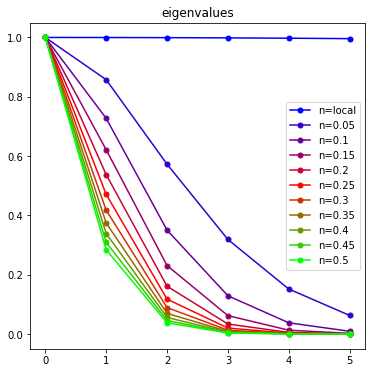

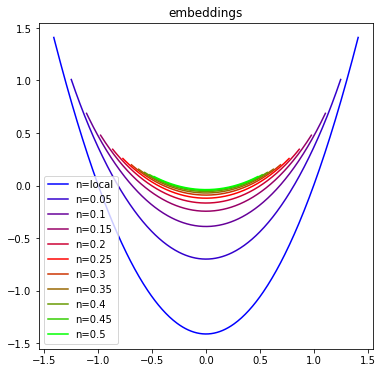

In [73]:
showeig(EIG3)
showemb(EMB3)

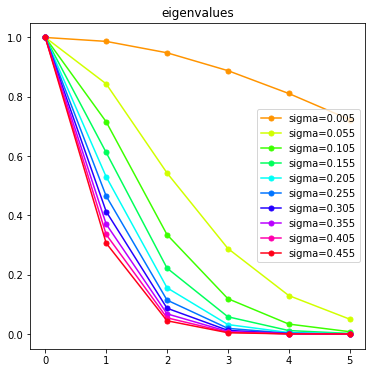

In [34]:
cmap = cm.hsv
col1 = cmap(arange(1,11)/10)

j = 0
for i in sigma[::10]:
    plot(range(dim),EIG3[str(i)],color=col1[j],marker='.',markersize=10,label='sigma='+str(i))
    j+=1


plt.gcf().set_size_inches(6,6)
plt.title('eigenvalues')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


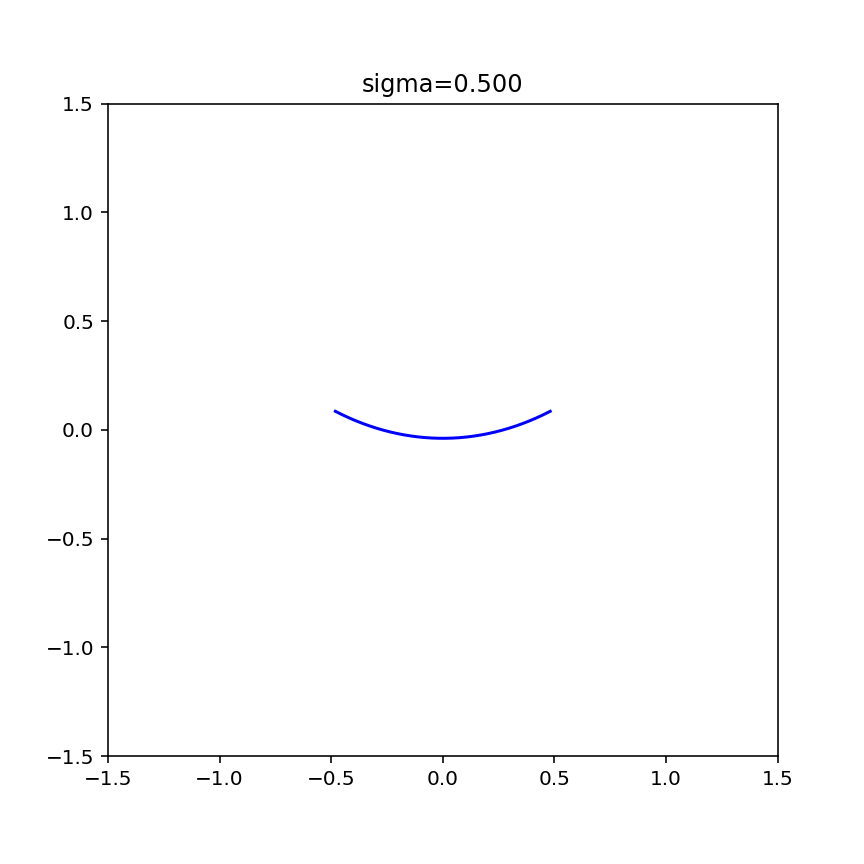

In [40]:
%matplotlib notebook

def animate2(t):
    line.set_data(EMB3[str(t)][:,1],EMB3[str(t)][:,2])
    plt.title('sigma='+str('%.3f'%t))
    return line,

fig = plt.figure(figsize=(6,6))
ax  = plt.axes(xlim =(-1.5, 1.5), ylim =(-1.5,1.5))
line, = ax.plot([],[],color='b')

vid = ani(fig, animate2, frames=sigma, repeat=0, interval=50)

#vid.save('a.gif')
plt.show()

In [41]:
%matplotlib inline

# 5. partition the dataset


### function: test5(n,p,dim=6,sigma=1,flag=1)

input

    n: initial size 
    p: number of time we double the size
    dim: embedding dimension (optional, default=5+1)
    sigma: scaling parameter (optional, default=1)
    flag: flag=1 if X=[0,1], flag=0 if X=[0,1) (optional, default=0)
    
output

    EMB: dictionary of embeddings
    EIG: dictionary of eigenvalues
	VEC: dictionary of eigenvectors

In [93]:
def test5(n,p,dim=6,sigma=1,flag=0):
    EMB = {}
    EIG = {}
    VEC = {}
     
    if flag: X = linspace(0,1,n)
    else:    X = arange(n)/n
        
    m = int(n/p)
    
    for i in range(p):
        EMB[str(i)], EIG[str(i)], VEC[str(i)] = DM(X[m*i:m*(i+1)],m,dim,sigma)
    
    return EMB, EIG, VEC

In [94]:
%%time

n = 500 #real['n']
p = 4

EMB5, EIG5, VEC5 = test5(n,p)

CPU times: user 10.7 ms, sys: 15 ms, total: 25.8 ms
Wall time: 6.29 ms


### eigenvalues & embeddings

eigenvalue:
[1.00000 0.01037 0.00004 0.00000 0.00000 0.00000] group_ 0
[1.00000 0.01037 0.00004 0.00000 0.00000 0.00000] group_ 1
[1.00000 0.01037 0.00004 0.00000 0.00000 0.00000] group_ 2
[1.00000 0.01037 0.00004 0.00000 0.00000 0.00000] group_ 3


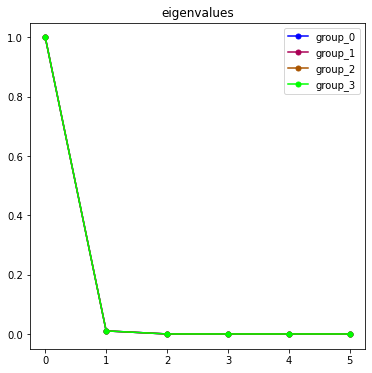

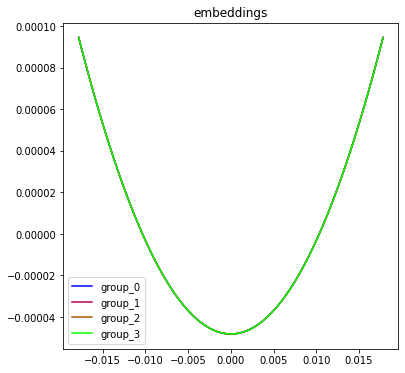

In [95]:
showeig(EIG5,lab='group_')
showemb(EMB5,lab='group_')

# 6. different intervals

Above testing have dataset being [0,1]. Now we compare the embedding of dataset c*[0,1] with different c's.

### function: test6(n,c,dim,sigma=1)

input

    n: data size
    c: as above, c is an array of scalars
    dim: embedding dimension
    sigma: global scaling parameter (optional, default=1)

output

    EMB: dictionary of embedding of each dataset
    EIG: dictionary of eigenvalues of each dataset

In [82]:
def test6(n,c,dim=6,sigma=1,flag=1):
    EMB = {}
    EIG = {}
    VEC = {}
        
    for i in c:
        if flag: X = linspace(0,i,n)
        else:    X = arange(n)/n*i
                
        if sigma is 1:
            EMB[str(i)], EIG[str(i)], VEC[str(i)] = DM(X,n,dim,sigma)
        else:
            EMB[str(i)], EIG[str(i)], VEC[str(i)] = DM(X,n,dim,sigma[i-1])

    
    return EMB, EIG, VEC

### sigma is a constant

In [85]:
%%time

n = 200
c = arange(10)+1

EMB6, EIG6, VEC6 = test6(n,c)

CPU times: user 32.7 ms, sys: 57 ms, total: 89.6 ms
Wall time: 20.5 ms


eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 1
[1.00000 0.47278 0.11863 0.02022 0.00258 0.00026] c= 2
[1.00000 0.70321 0.31923 0.10923 0.02942 0.00648] c= 3
[1.00000 0.82397 0.50419 0.25085 0.10432 0.03691] c= 4
[1.00000 0.88687 0.63990 0.39461 0.21269 0.10118] c= 5
[1.00000 0.92209 0.73336 0.51645 0.32760 0.18858] c= 6
[1.00000 0.94339 0.79741 0.61258 0.43286 0.28316] c= 7
[1.00000 0.95712 0.84209 0.68653 0.52283 0.37392] c= 8
[1.00000 0.96644 0.87403 0.74318 0.59730 0.45564] c= 9
[1.00000 0.97305 0.89747 0.78686 0.65812 0.52674] c= 10


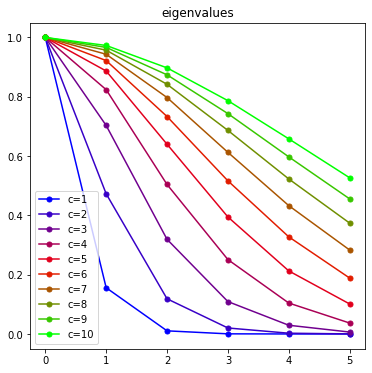

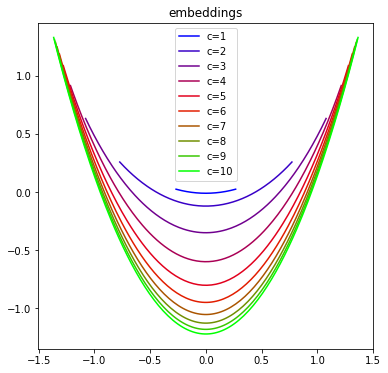

In [86]:
showeig(EIG6,lab='c=')
showemb(EMB6,lab='c=')

### sigma scale with length of dataset

In [87]:
%%time

sigma2 = c
print('sigma=',sigma2,'\n')

EMB62, EIG62, VEC62 = test6(n,c,sigma=sigma2)

sigma= [ 1  2  3  4  5  6  7  8  9 10] 

CPU times: user 36.3 ms, sys: 62.3 ms, total: 98.6 ms
Wall time: 22.8 ms


eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 1
[1.00000 0.28532 0.03816 0.00331 0.00021 0.00001] c= 2
[1.00000 0.38958 0.07603 0.00983 0.00094 0.00007] c= 3
[1.00000 0.47278 0.11863 0.02022 0.00258 0.00026] c= 4
[1.00000 0.53932 0.16233 0.03402 0.00538 0.00068] c= 5
[1.00000 0.59300 0.20502 0.05051 0.00948 0.00143] c= 6
[1.00000 0.63680 0.24565 0.06895 0.01491 0.00261] c= 7
[1.00000 0.67297 0.28376 0.08870 0.02159 0.00427] c= 8
[1.00000 0.70321 0.31923 0.10923 0.02942 0.00648] c= 9
[1.00000 0.72876 0.35212 0.13013 0.03824 0.00925] c= 10


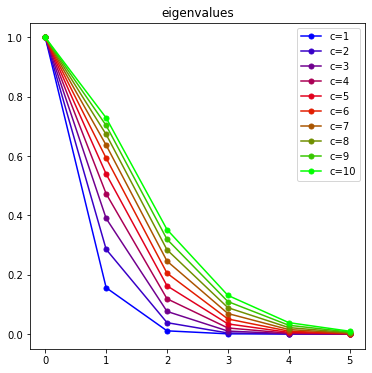

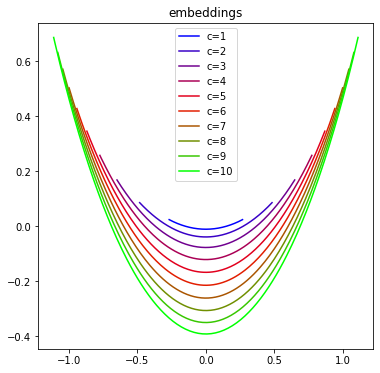

In [88]:
showeig(EIG62,lab='c=')
showemb(EMB62,lab='c=')

### sigma scale with length^2 of dataset

In [89]:
%%time

sigma3 = c**2
print('sigma=',sigma3,'\n')

EMB63, EIG63, VEC63 = test6(n,c,sigma=sigma3)

sigma= [  1   4   9  16  25  36  49  64  81 100] 

CPU times: user 35.8 ms, sys: 63.2 ms, total: 99 ms
Wall time: 22.6 ms


eigenvalue:
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 1
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 2
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 3
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 4
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 5
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 6
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 7
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 8
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 9
[1.00000 0.15593 0.01057 0.00046 0.00001 0.00000] c= 10


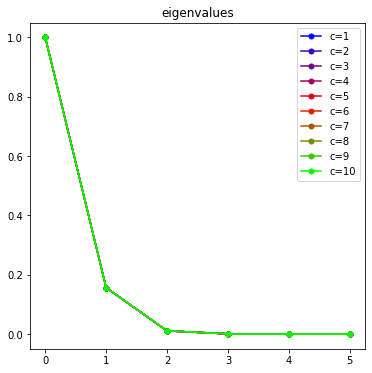

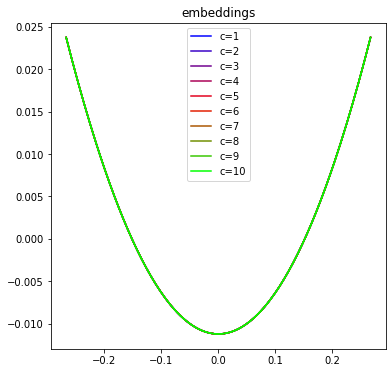

In [90]:
showeig(EIG63,lab='c=')
showemb(EMB63,lab='c=')